Import nessecary dependencies

In [92]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import re
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

The unemployment dataset is as TSV (tab separated format) file. We use read_csv with \t separator for reading the data.

In [93]:
data_df = pd.read_csv("datasets/une_rt_m.tsv", sep='\t')
data_df.head()

,"s_adj,age,unit,sex,geo\time",2020M07,2020M06,2020M05,2020M04,2020M03,2020M02,2020M01,2019M12,2019M11,...,1983M10,1983M09,1983M08,1983M07,1983M06,1983M05,1983M04,1983M03,1983M02,1983M01
0,"NSA,TOTAL,PC_ACT,F,AT",6.0,6.2,5.2,4.9,4.7,4.1,4.4,4.0,3.9,...,:,:,:,:,:,:,:,:,:,:
1,"NSA,TOTAL,PC_ACT,F,BE",5.4,5.0,5.0,5.2,5.0,4.9,4.8,4.6,4.5,...,:,:,:,:,:,:,:,:,:,:
2,"NSA,TOTAL,PC_ACT,F,BG",3.9,3.9,4.2,4.7,4.1,4.2,4.3,3.9,3.8,...,:,:,:,:,:,:,:,:,:,:
3,"NSA,TOTAL,PC_ACT,F,CH",:,4.4,4.3,4.4,4.6,4.6,4.5,4.1,4.0,...,:,:,:,:,:,:,:,:,:,:
4,"NSA,TOTAL,PC_ACT,F,CY",7.2,6.6,6.4,6.8,7.1,7.5,7.9,7.5,7.7,...,:,:,:,:,:,:,:,:,:,:


In [94]:
data_df.shape

(2131, 452)

Read the contry codes data from csv file.

In [95]:
country_codes_df = pd.read_csv("datasets/wikipedia-iso-country-codes.csv")
country_codes_df.columns = ['Country', 'C2', 'C3', 'Numeric', 'Iso']
country_codes_df.head()

,Country,C2,C3,Numeric,Iso
0,Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW
1,Zambia,ZM,ZMB,894,ISO 3166-2:ZM
2,Yemen,YE,YEM,887,ISO 3166-2:YE
3,Western Sahara,EH,ESH,732,ISO 3166-2:EH
4,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF


Categorize the data in several dimensions, including country, age, unit, sex and s_adj.

In [96]:
        
data_df['C2'] = data_df['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[-1])
data_df['age'] = data_df['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[1])
data_df['unit'] = data_df['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[2])
data_df['sex'] = data_df['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[3])
data_df['s_adj'] = data_df['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[0])

data_df.head()

,"s_adj,age,unit,sex,geo\time",2020M07,2020M06,2020M05,2020M04,2020M03,2020M02,2020M01,2019M12,2019M11,...,1983M05,1983M04,1983M03,1983M02,1983M01,C2,age,unit,sex,s_adj
0,"NSA,TOTAL,PC_ACT,F,AT",6.0,6.2,5.2,4.9,4.7,4.1,4.4,4.0,3.9,...,:,:,:,:,:,AT,TOTAL,PC_ACT,F,NSA
1,"NSA,TOTAL,PC_ACT,F,BE",5.4,5.0,5.0,5.2,5.0,4.9,4.8,4.6,4.5,...,:,:,:,:,:,BE,TOTAL,PC_ACT,F,NSA
2,"NSA,TOTAL,PC_ACT,F,BG",3.9,3.9,4.2,4.7,4.1,4.2,4.3,3.9,3.8,...,:,:,:,:,:,BG,TOTAL,PC_ACT,F,NSA
3,"NSA,TOTAL,PC_ACT,F,CH",:,4.4,4.3,4.4,4.6,4.6,4.5,4.1,4.0,...,:,:,:,:,:,CH,TOTAL,PC_ACT,F,NSA
4,"NSA,TOTAL,PC_ACT,F,CY",7.2,6.6,6.4,6.8,7.1,7.5,7.9,7.5,7.7,...,:,:,:,:,:,CY,TOTAL,PC_ACT,F,NSA


Let's see the data.

In [97]:
print(f"countries:\n{list(data_df.C2.unique())}")

countries:
['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EA', 'EA18', 'EA19', 'EE', 'EL', 'ES', 'EU25', 'EU27_2007', 'EU27_2020', 'EU28', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'JP', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'UK', 'US', 'TR']


In [98]:
print(f"sex:\n{list(data_df.sex.unique())}")

sex:
['F', 'M', 'T']


In [99]:
print(f"age intervals:\n{list(data_df.age.unique())}")

age intervals:
['TOTAL', 'Y25-74', 'Y_LT25']


In [100]:
print(f"unit:\n{list(data_df.unit.unique())}")

unit:
['PC_ACT', 'THS_PER']


In [101]:
print(f"s_adj:\n{list(data_df.s_adj.unique())}")

s_adj:
['NSA', 'SA', 'TC']


We select only a part of columns for further analysis.
More specificaly, we are selecting country code (2 letters), age, unit, sex, s_adj and months from Jan 2010 to June 2020.

In [102]:
selected_cols = ['C2','age','unit','sex', 's_adj', 
                '2020M07 ', '2020M06 ', '2020M05 ', '2020M04 ','2020M03 ','2020M02 ','2020M01 ',
                '2019M12 ','2019M11 ','2019M10 ','2019M09 ','2019M08 ','2019M07 ',
                '2019M06 ','2019M05 ','2019M04 ','2019M03 ','2019M02 ','2019M01 ',
                '2018M12 ','2018M11 ','2018M10 ','2018M09 ','2018M08 ','2018M07 ',
                '2018M06 ','2018M05 ','2018M04 ','2018M03 ','2018M02 ','2018M01 ',
                '2017M12 ','2017M11 ','2017M10 ','2017M09 ','2017M08 ','2017M07 ',
                '2017M06 ','2017M05 ','2017M04 ','2017M03 ','2017M02 ','2017M01 ',
                '2016M12 ','2016M11 ','2016M10 ','2016M09 ','2016M08 ','2016M07 ',
                '2016M06 ','2016M05 ','2016M04 ','2016M03 ','2016M02 ','2016M01 ',
                '2015M12 ','2015M11 ','2015M10 ','2015M09 ','2015M08 ','2015M07 ',
                '2015M06 ','2015M05 ','2015M04 ','2015M03 ','2015M02 ','2015M01 ',
                '2014M12 ','2014M11 ','2014M10 ','2014M09 ','2014M08 ','2014M07 ',
                '2014M06 ','2014M05 ','2014M04 ','2014M03 ','2014M02 ','2014M01 ',
                '2013M12 ','2013M11 ','2013M10 ','2013M09 ','2013M08 ','2013M07 ',
                '2013M06 ','2013M05 ','2013M04 ','2013M03 ','2013M02 ','2013M01 ',
                '2012M12 ','2012M11 ','2012M10 ','2012M09 ','2012M08 ','2012M07 ',
                '2012M06 ','2012M05 ','2012M04 ','2012M03 ','2012M02 ','2012M01 ',
                '2011M12 ','2011M11 ','2011M10 ','2011M09 ','2011M08 ','2011M07 ',
                '2011M06 ','2011M05 ','2011M04 ','2011M03 ','2011M02 ','2011M01 ',
                '2010M12 ','2010M11 ','2010M10 ','2010M09 ','2010M08 ','2010M07 ',
                '2010M06 ','2010M05 ','2010M04 ','2010M03 ','2010M02 ','2010M01 ',]
data_sel_df = data_df[selected_cols]

Merge the unemployment data with the country codes data.

In [103]:
data_sel_df = data_sel_df.merge(country_codes_df, on="C2")
data_sel_df.head()

,C2,age,unit,sex,s_adj,2020M07,2020M06,2020M05,2020M04,2020M03,...,2010M06,2010M05,2010M04,2010M03,2010M02,2010M01,Country,C3,Numeric,Iso
0,AT,TOTAL,PC_ACT,F,NSA,6.0,6.2,5.2,4.9,4.7,...,4.5,4.5,5.0,4.5,4.9,4.5,Austria,AUT,40,ISO 3166-2:AT
1,AT,TOTAL,PC_ACT,M,NSA,5.5,6.2,6.1,5.2,5.0,...,5.0,4.9,5.5,6.2,6.0,5.2,Austria,AUT,40,ISO 3166-2:AT
2,AT,TOTAL,PC_ACT,T,NSA,5.7,6.2,5.7,5.1,4.9,...,4.7,4.8,5.2,5.4,5.5,4.9,Austria,AUT,40,ISO 3166-2:AT
3,AT,TOTAL,THS_PER,F,NSA,129,132,108,100,97,...,76,93,104,76,100,93,Austria,AUT,40,ISO 3166-2:AT
4,AT,TOTAL,THS_PER,M,NSA,134,149,144,121,118,...,95,118,133,120,142,122,Austria,AUT,40,ISO 3166-2:AT


Data transforming.

Use melt method to pivot time series columns. For each value of time series we introduce additional rows.

In [104]:
data_tr_df = data_sel_df.melt(id_vars=["Country", "age", "unit", "sex", "s_adj", "C2", "C3", "Numeric", "Iso"], 
        var_name="Date", 
        value_name="Unemployment_Rate")

data_tr_df.head()

,Country,age,unit,sex,s_adj,C2,C3,Numeric,Iso,Date,Unemployment_Rate
0,Austria,TOTAL,PC_ACT,F,NSA,AT,AUT,40,ISO 3166-2:AT,2020M07,6.0
1,Austria,TOTAL,PC_ACT,M,NSA,AT,AUT,40,ISO 3166-2:AT,2020M07,5.5
2,Austria,TOTAL,PC_ACT,T,NSA,AT,AUT,40,ISO 3166-2:AT,2020M07,5.7
3,Austria,TOTAL,THS_PER,F,NSA,AT,AUT,40,ISO 3166-2:AT,2020M07,129
4,Austria,TOTAL,THS_PER,M,NSA,AT,AUT,40,ISO 3166-2:AT,2020M07,134


Remove C3 column since it is not needed for analysis.

In [105]:
data_tr_df = data_tr_df.drop('C3', axis=1)
data_tr_df.head()

,Country,age,unit,sex,s_adj,C2,Numeric,Iso,Date,Unemployment_Rate
0,Austria,TOTAL,PC_ACT,F,NSA,AT,40,ISO 3166-2:AT,2020M07,6.0
1,Austria,TOTAL,PC_ACT,M,NSA,AT,40,ISO 3166-2:AT,2020M07,5.5
2,Austria,TOTAL,PC_ACT,T,NSA,AT,40,ISO 3166-2:AT,2020M07,5.7
3,Austria,TOTAL,THS_PER,F,NSA,AT,40,ISO 3166-2:AT,2020M07,129
4,Austria,TOTAL,THS_PER,M,NSA,AT,40,ISO 3166-2:AT,2020M07,134


The shape of data before and after melt.

In [106]:
print(f"Data shape before melt {data_sel_df.shape}")
print(f"Data shape after melt {data_tr_df.shape}")

Data shape before melt (1645, 136)
Data shape after melt (208915, 10)


Cleaning the data. We remove the non-digit data and trim the spaces.

In this dataset the null values are presented as ": ", so we check how many null values we have in this specific column.

In [107]:
count = (data_tr_df['Unemployment_Rate'] == ': ').sum()
print(f"Number of ':' values in 'Unemployment_Rate': {count}")

Number of ':' values in 'Unemployment_Rate': 2903


We have a small amount of data that are null we choose to delete those data and keep the integrity, since it will not effect the analysis result.

In [108]:
data_tr_df['Unemployment_Rate'] = data_tr_df['Unemployment_Rate'].apply(lambda x: re.sub(r"[a-zA-Z: ]", "", x))
data_tr_df['Unemployment_Rate'] = data_tr_df['Unemployment_Rate'].apply(lambda x: x.replace(" ",""))

data_tr_df = data_tr_df.loc[~(data_tr_df.Unemployment_Rate=="")]

data_tr_df['Unemployment_Rate'] = data_tr_df['Unemployment_Rate'].apply(lambda x: float(x))

In [109]:
print(f"distinct values: {len(list(data_tr_df['Unemployment_Rate'].unique()))}")
print(f"samples values: {data_tr_df['Unemployment_Rate'].unique()}")

distinct values: 5304
samples values: [6.0000e+00 5.5000e+00 5.7000e+00 ... 8.9410e+03 1.4987e+04 1.1059e+04]


Check for any null values

In [110]:
print(data_tr_df.isnull().sum())

Country              0
age                  0
unit                 0
sex                  0
s_adj                0
C2                   0
Numeric              0
Iso                  0
Date                 0
Unemployment_Rate    0
dtype: int64


Check for duplicated data

In [111]:
print('Duplicated data: ',data_tr_df.duplicated().sum())

Duplicated data:  0


Transfrom 'Date' column format.

In [112]:
data_tr_df['Date'] = pd.to_datetime(data_tr_df['Date'], format='%YM%m ', errors='coerce')

data_tr_df['Month'] = data_tr_df['Date'].dt.strftime('%B')
data_tr_df['Year'] = data_tr_df['Date'].dt.year

data_tr_df = data_tr_df.drop('Date', axis=1)

data_tr_df.head()

,Country,age,unit,sex,s_adj,C2,Numeric,Iso,Unemployment_Rate,Month,Year
0,Austria,TOTAL,PC_ACT,F,NSA,AT,40,ISO 3166-2:AT,6.0,July,2020
1,Austria,TOTAL,PC_ACT,M,NSA,AT,40,ISO 3166-2:AT,5.5,July,2020
2,Austria,TOTAL,PC_ACT,T,NSA,AT,40,ISO 3166-2:AT,5.7,July,2020
3,Austria,TOTAL,THS_PER,F,NSA,AT,40,ISO 3166-2:AT,129.0,July,2020
4,Austria,TOTAL,THS_PER,M,NSA,AT,40,ISO 3166-2:AT,134.0,July,2020


Reorder and format column names.

In [113]:
data_tr_df = data_tr_df[['Country', 'age', 'unit', 'sex', 'C2', 'Numeric', 'Iso', 'Month', 'Year', 'Unemployment_Rate']]

data_tr_df.columns = [col.upper() for col in data_tr_df.columns]

data_tr_df.head()

,COUNTRY,AGE,UNIT,SEX,C2,NUMERIC,ISO,MONTH,YEAR,UNEMPLOYMENT_RATE
0,Austria,TOTAL,PC_ACT,F,AT,40,ISO 3166-2:AT,July,2020,6.0
1,Austria,TOTAL,PC_ACT,M,AT,40,ISO 3166-2:AT,July,2020,5.5
2,Austria,TOTAL,PC_ACT,T,AT,40,ISO 3166-2:AT,July,2020,5.7
3,Austria,TOTAL,THS_PER,F,AT,40,ISO 3166-2:AT,July,2020,129.0
4,Austria,TOTAL,THS_PER,M,AT,40,ISO 3166-2:AT,July,2020,134.0


Filter for EU countries.

In [114]:
eu_countries = ['AT','BE','BG','CY','CZ','DE','DK','EE','ES','FI','FR','GR','HR','HU','IE','IT','LT','LU','LV','MT','NL','PO','PT','RO','SE','SI','SK']  # Add the correct EU country codes
data_tr_df = data_tr_df[data_tr_df['C2'].isin(eu_countries)]
data_tr_df.shape

(168691, 10)

Applying Z-Score method to identify outliers.

In [115]:
data_tr_df['Z_Score'] = np.abs(stats.zscore(data_tr_df['UNEMPLOYMENT_RATE'], nan_policy='omit'))
threshold = 3
outliers_z = data_tr_df[data_tr_df['Z_Score'] > threshold]
print("Outliers identified by Z-Score method:")
print(outliers_z.head())

Outliers identified by Z-Score method:
     COUNTRY     AGE     UNIT SEX  C2  NUMERIC            ISO MONTH  YEAR  \
329  Germany   TOTAL  THS_PER   T  DE      276  ISO 3166-2:DE  July  2020   
335  Germany  Y25-74  THS_PER   T  DE      276  ISO 3166-2:DE  July  2020   
347  Germany   TOTAL  THS_PER   T  DE      276  ISO 3166-2:DE  July  2020   
353  Germany  Y25-74  THS_PER   T  DE      276  ISO 3166-2:DE  July  2020   
365  Germany   TOTAL  THS_PER   T  DE      276  ISO 3166-2:DE  July  2020   

     UNEMPLOYMENT_RATE   Z_Score  
329             1983.0  3.934924  
335             1665.0  3.250953  
347             1937.0  3.835985  
353             1690.0  3.304725  
365             1937.0  3.835985  


Visualise the outliers identified by Z-Score.

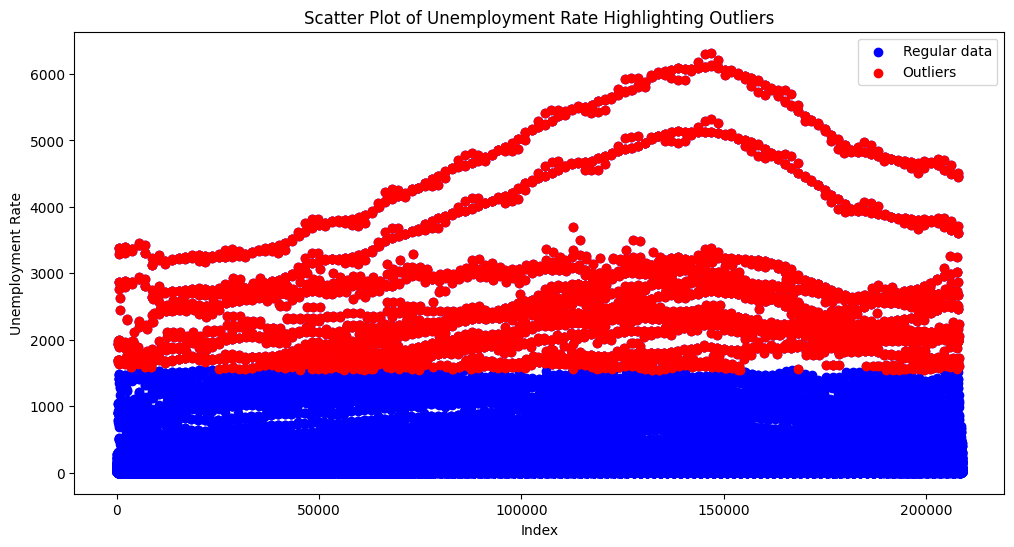

In [116]:
# Scatter plot for all data
plt.figure(figsize=(12, 6))
plt.scatter(data_tr_df.index, data_tr_df['UNEMPLOYMENT_RATE'], color='blue', label='Regular data')

# Scatter plot for outliers
plt.scatter(outliers_z.index, outliers_z['UNEMPLOYMENT_RATE'], color='red', label='Outliers')
plt.title("Scatter Plot of Unemployment Rate Highlighting Outliers")
plt.xlabel("Index")
plt.ylabel("Unemployment Rate")
plt.legend()
plt.show()

When looking the statistics we identify that the difference between maximum and minimum is big and we analyze further.

In [117]:
print(data_tr_df.describe())

             NUMERIC           YEAR  UNEMPLOYMENT_RATE        Z_Score
count  168691.000000  168691.000000      168691.000000  168691.000000
mean      382.222430    2014.788578         153.526511       0.440362
std       214.183286       3.053046         464.933775       0.897823
min        40.000000    2010.000000           0.000000       0.001018
25%       208.000000    2012.000000           7.700000       0.242028
50%       372.000000    2015.000000          19.000000       0.302682
75%       528.000000    2017.000000          91.000000       0.317523
max       752.000000    2020.000000        6321.000000      13.265312


The observed difference between the maximum and minimum values in the 'Unemployment_Rate' column arises from the inclusion of data measured in both percentage terms and as counts in thousands of people. To facilitate more precise analysis and visualization, it is advantageous to segregate the data into two distinct DataFrames, each corresponding to one of these measurement units.

In [118]:
ts_df_pct = data_tr_df[data_tr_df["UNIT"] == "PC_ACT"].drop("UNIT", axis=1)  # Percentage Active Population
ts_df_th = data_tr_df[data_tr_df["UNIT"] == "THS_PER"].drop("UNIT", axis=1)  # Thousands Person
ts_df_pct.head(5)

,COUNTRY,AGE,SEX,C2,NUMERIC,ISO,MONTH,YEAR,UNEMPLOYMENT_RATE,Z_Score
0,Austria,TOTAL,F,AT,40,ISO 3166-2:AT,July,2020,6.0,0.317307
1,Austria,TOTAL,M,AT,40,ISO 3166-2:AT,July,2020,5.5,0.318383
2,Austria,TOTAL,T,AT,40,ISO 3166-2:AT,July,2020,5.7,0.317953
6,Austria,Y25-74,F,AT,40,ISO 3166-2:AT,July,2020,5.2,0.319028
7,Austria,Y25-74,M,AT,40,ISO 3166-2:AT,July,2020,4.6,0.320319


In [119]:
print(ts_df_pct.describe())

            NUMERIC          YEAR  UNEMPLOYMENT_RATE       Z_Score
count  84335.000000  84335.000000       84335.000000  84335.000000
mean     382.244122   2014.787929          12.163285      0.304051
std      214.188431      3.052691           8.881315      0.019102
min       40.000000   2010.000000           1.100000      0.199441
25%      208.000000   2012.000000           6.000000      0.296874
50%      372.000000   2015.000000           9.100000      0.310640
75%      528.000000   2017.000000          15.500000      0.317307
max      752.000000   2020.000000          60.800000      0.327847


Calculate Z-Scores for the 'PC_ACT' subset

In [120]:
ts_df_pct['Z_Score'] = np.abs(stats.zscore(ts_df_pct['UNEMPLOYMENT_RATE'], nan_policy='omit'))
threshold = 3
outliers_pct_z = ts_df_pct[ts_df_pct['Z_Score'] > threshold]
print("Outliers identified by Z-Score method:")
print(outliers_pct_z.head())

Outliers identified by Z-Score method:
    COUNTRY     AGE SEX  C2  NUMERIC            ISO MONTH  YEAR  \
498   Spain  Y_LT25   F  ES      724  ISO 3166-2:ES  July  2020   
499   Spain  Y_LT25   M  ES      724  ISO 3166-2:ES  July  2020   
500   Spain  Y_LT25   T  ES      724  ISO 3166-2:ES  July  2020   
516   Spain  Y_LT25   F  ES      724  ISO 3166-2:ES  July  2020   
517   Spain  Y_LT25   M  ES      724  ISO 3166-2:ES  July  2020   

     UNEMPLOYMENT_RATE   Z_Score  
498               40.0  3.134320  
499               40.2  3.156839  
500               40.1  3.145579  
516               42.0  3.359513  
517               41.4  3.291955  


Visualize the 'PC_ACT' subset outliers using scatter plot.

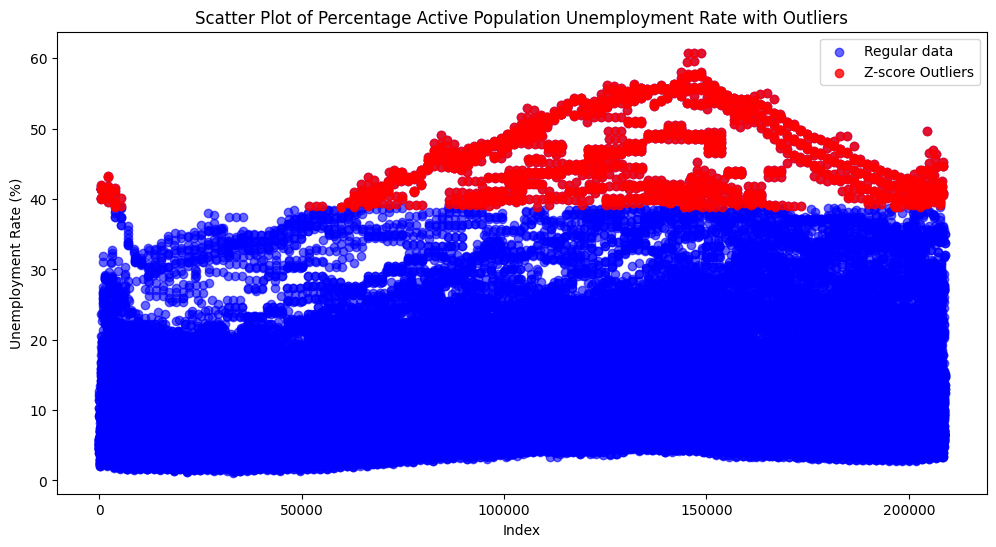

In [121]:
plt.figure(figsize=(12, 6))
plt.scatter(ts_df_pct.index, ts_df_pct['UNEMPLOYMENT_RATE'], color='blue', label='Regular data', alpha=0.6)
# Highlight the outliers
plt.scatter(outliers_pct_z.index, outliers_pct_z['UNEMPLOYMENT_RATE'], color='red', label='Z-score Outliers', alpha=0.8)
plt.title("Scatter Plot of Percentage Active Population Unemployment Rate with Outliers")
plt.xlabel("Index")
plt.ylabel("Unemployment Rate (%)")
plt.legend()
plt.show()

Anomalies detection using Isolation Forest

In [122]:
param_grid = {'contamination': [0.01, 0.05, 0.1, 0.2]}  
iso_forest = IsolationForest()
grid_search = GridSearchCV(iso_forest, param_grid, scoring='roc_auc') 
grid_search.fit(ts_df_pct[['UNEMPLOYMENT_RATE']])

print("Best contamination:", grid_search.best_params_['contamination'])

Best contamination: 0.01


Use Isolation Forest model

In [123]:
iso_forest_model = IsolationForest(contamination=grid_search.best_params_['contamination'])  # Adjust contamination based on your dataset
iso_forest_model.fit(ts_df_pct[['UNEMPLOYMENT_RATE']])

ts_df_pct['IsolationForest_Outlier'] = iso_forest_model.predict(ts_df_pct[['UNEMPLOYMENT_RATE']])

print("Isolation Forest Outliers:")
print(ts_df_pct[ts_df_pct['IsolationForest_Outlier'] == -1])

Isolation Forest Outliers:
       COUNTRY     AGE SEX  C2  NUMERIC            ISO     MONTH  YEAR  \
81103    Spain  Y_LT25   F  ES      724  ISO 3166-2:ES      June  2016   
81105    Spain  Y_LT25   T  ES      724  ISO 3166-2:ES      June  2016   
81121    Spain  Y_LT25   F  ES      724  ISO 3166-2:ES      June  2016   
81122    Spain  Y_LT25   M  ES      724  ISO 3166-2:ES      June  2016   
81123    Spain  Y_LT25   T  ES      724  ISO 3166-2:ES      June  2016   
...        ...     ...  ..  ..      ...            ...       ...   ...   
206707  Latvia  Y_LT25   M  LV      428  ISO 3166-2:LV  February  2010   
206725  Latvia  Y_LT25   M  LV      428  ISO 3166-2:LV  February  2010   
208334  Latvia  Y_LT25   M  LV      428  ISO 3166-2:LV   January  2010   
208352  Latvia  Y_LT25   M  LV      428  ISO 3166-2:LV   January  2010   
208370  Latvia  Y_LT25   M  LV      428  ISO 3166-2:LV   January  2010   

        UNEMPLOYMENT_RATE   Z_Score  IsolationForest_Outlier  
81103                

Visualize the Isolation Forest outliers on the time series plot. We see that there are some data marked as anomalies but after checking manually the data are nedeed for the analyse.

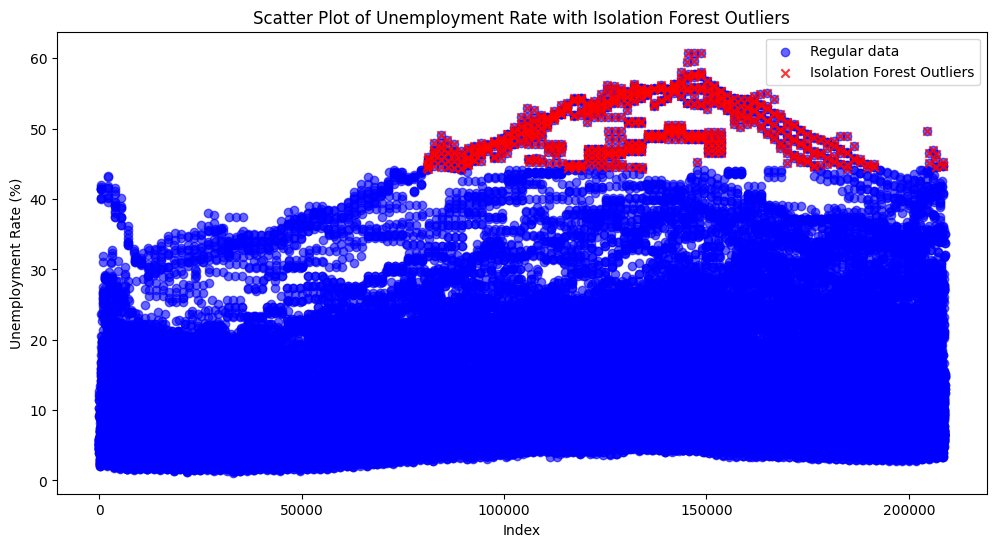

In [127]:
plt.figure(figsize=(12, 6))
plt.scatter(ts_df_pct.index, ts_df_pct['UNEMPLOYMENT_RATE'], color='blue', label='Regular data', alpha=0.6)

plt.scatter(ts_df_pct[ts_df_pct['IsolationForest_Outlier'] == -1].index,
            ts_df_pct['UNEMPLOYMENT_RATE'][ts_df_pct['IsolationForest_Outlier'] == -1],
            color='red', label='Isolation Forest Outliers', alpha=0.8, marker='x')  # Use 'x' marker for outliers

plt.title("Scatter Plot of Unemployment Rate with Isolation Forest Outliers")
plt.xlabel("Index")
plt.ylabel("Unemployment Rate (%)")
plt.legend()
plt.show()